#Источник
В основе этого блокнота
Kernel "Keras CNN Dog or Cat Classification" by Uysim

https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification

#Необходимые ресурсы

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import train_test_split
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
import random
import os
import zipfile
import io, shutil

#Загружаем токен аутентификации

In [3]:
file = files.upload()

Saving kaggle.json to kaggle.json


#Копируем токен в каталог .kaggle

In [4]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

In [5]:
!chmod 600 /root/.kaggle/kaggle.json

#Загружаем данные с сайта Kaggle

In [6]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 97% 790M/814M [00:07<00:00, 115MB/s] 
100% 814M/814M [00:07<00:00, 110MB/s]


In [7]:
!unzip dogs-vs-cats-redux-kernels-edition.zip

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.zip               


In [8]:
!ls

dogs-vs-cats-redux-kernels-edition.zip	sample_submission.csv  train.zip
sample_data				test.zip


In [9]:
!head sample_submission.csv

id,label
1,0.5
2,0.5
3,0.5
4,0.5
5,0.5
6,0.5
7,0.5
8,0.5
9,0.5


In [10]:
!unzip train.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/d

In [11]:
!unzip test.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: test/5499.jpg           
  inflating: test/55.jpg             
  inflating: test/550.jpg            
  inflating: test/5500.jpg           
  inflating: test/5501.jpg           
  inflating: test/5502.jpg           
  inflating: test/5503.jpg           
  inflating: test/5504.jpg           
  inflating: test/5505.jpg           
  inflating: test/5506.jpg           
  inflating: test/5507.jpg           
  inflating: test/5508.jpg           
  inflating: test/5509.jpg           
  inflating: test/551.jpg            
  inflating: test/5510.jpg           
  inflating: test/5511.jpg           
  inflating: test/5512.jpg           
  inflating: test/5513.jpg           
  inflating: test/5514.jpg           
  inflating: test/5515.jpg           
  inflating: test/5516.jpg           
  inflating: test/5517.jpg           
  inflating: test/5518.jpg           
  inflating: test/5519.jpg           
  inflating: test/55

In [12]:
# подсчитаем количество файлов в датасете train
!find /content/train -type f| wc -l

25000


In [13]:
# подсчитаем количество файлов в датасете test
!find /content/test -type f| wc -l

12500


#Разметка обучающей выборки
1 = dog, 0 = cat

In [14]:
filenames = os.listdir("/content/train/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if 'cat' in category:
        categories.append(0)
    else:
        categories.append(1)

df = pd.DataFrame({
    'filename': filenames,
    'label': categories
})

In [15]:
# посмотрим на первые 5 записей
df.head()

,filename,label
0,dog.9630.jpg,1
1,dog.11012.jpg,1
2,cat.4493.jpg,0
3,dog.494.jpg,1
4,dog.1904.jpg,1


In [16]:
# общая информация о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  25000 non-null  object
 1   label     25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


#Определим константы

In [17]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

#Посмотрим на распределение изображений

<Axes: >

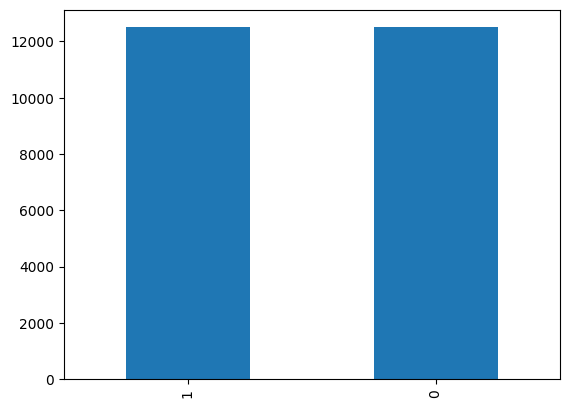

In [18]:
df['label'].value_counts().plot.bar()

#Посмотрим на случайное изображение из датасета

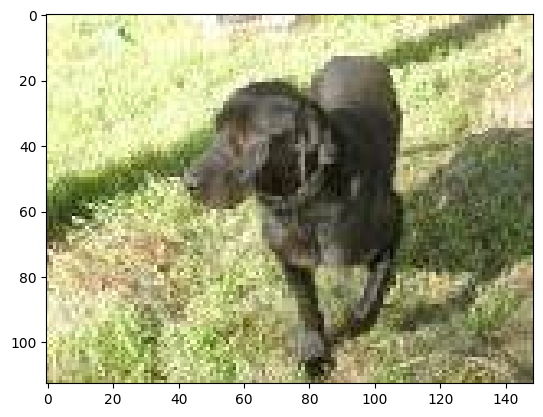

In [19]:
sample = random.choice(filenames)
image = load_img("/content/train/" + sample)
plt.imshow(image)

#Построение модели

In [20]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras import Sequential

In [21]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',
                 input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 класса - собаки, кошки

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

#Callbacks

In [22]:
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

#Early Stop

In [23]:
earlystop = EarlyStopping(patience=5)

#Learning Rate Reduction
Будем уменьшать скорость обучения, если точность за 2 эпохи не увеличится.

In [24]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=2,
                                            factor=0.5,
                                            min_lr=0.00001)

#ModelCheckpoint
Будем сохранять лучший результат модели

In [25]:
modelCheckpoint = ModelCheckpoint("model-cnn.h5",
                                  monitor='val_accuracy',
                                  verbose=2,
                                  save_best_only=True)

In [26]:
callbacks = [earlystop, learning_rate_reduction, modelCheckpoint]

#Подготовка данных
Так как мы будем использовать image generator с class_mode = "categorical", нам нужно преобразовать категорию столбца в тип объекта - строка.

Затем imagenerator преобразует строки в one-hot encoding для решения задачи классификации.

Таким образом, мы будем конвертировать 1 в 'dog' и 0 - в 'cat'.

In [27]:
df["label"] = df["label"].replace({0: 'cat', 1: 'dog'})

In [28]:
# сформируем обучающую и проверочную выборку
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: >

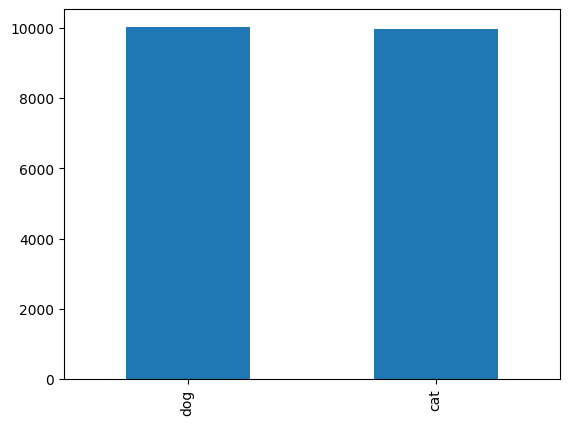

In [29]:
# посмотрим на распределение обучающей выборки
train_df['label'].value_counts().plot.bar()

<Axes: >

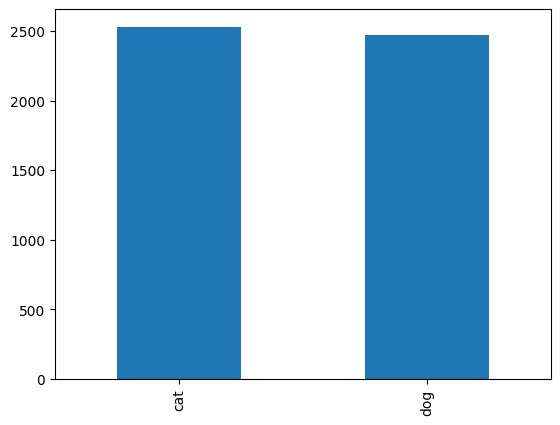

In [30]:
# посмотрим на распределение проверочной выборки
validate_df['label'].value_counts().plot.bar()

In [31]:
# запишем данные для обучения и проверки в переменные
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
# определим batch_size
batch_size=32

#ImageDataGenerator для обучающей и проверочной выборок

Применим ImageDataGenerator для трансформации изображений для обучающей выборки

In [32]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/train/",
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


Применим ImageDataGenerator для трансформации изображений для проверочной выборки

In [33]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/train/",
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


Посмотрим на пример трансформации изображения

In [34]:
example_df = train_df.sample(n=2).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/train/",
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 2 validated image filenames belonging to 2 classes.


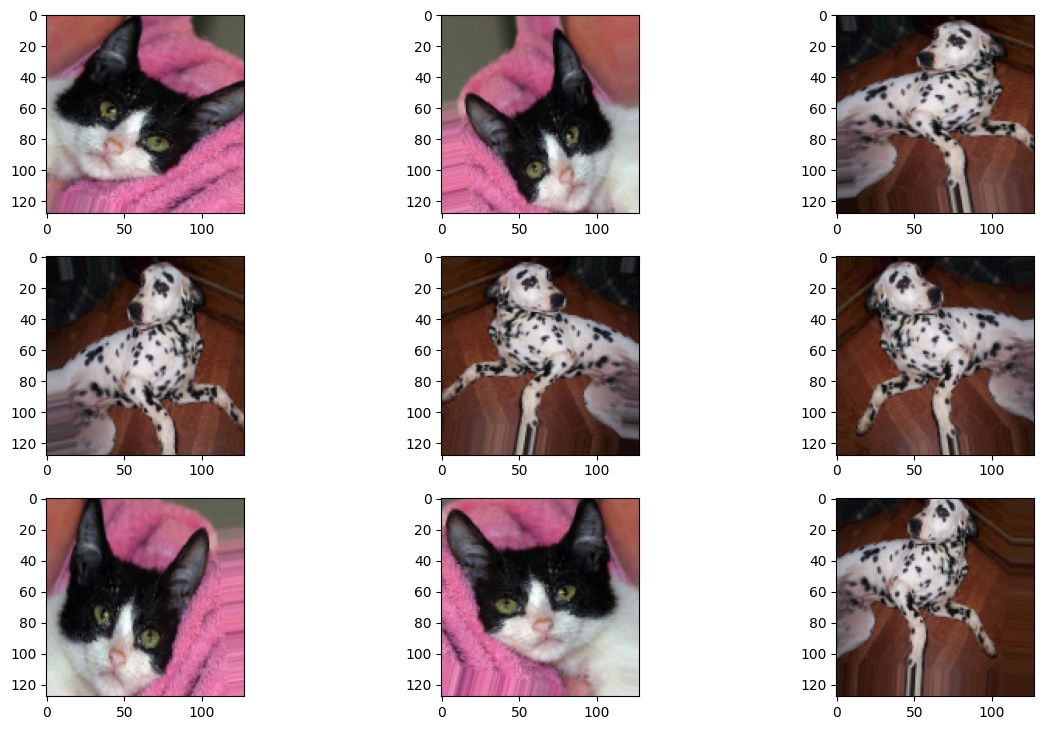

In [35]:
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

#Обучение модели

In [36]:
epochs=3 if FAST_RUN else 25
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks)


Epoch 1/25
625/625 [==============================] - ETA: 0s - loss: 0.7212 - accuracy: 0.6545
Epoch 00001: val_accuracy improved from -inf to 0.69071, saving model to model-cnn.h5
625/625 [==============================] - 148s 215ms/step - loss: 0.7212 - accuracy: 0.6545 - val_loss: 0.6462 - val_accuracy: 0.6907 - lr: 0.0010
Epoch 2/25


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - ETA: 0s - loss: 0.5062 - accuracy: 0.7539
Epoch 00002: val_accuracy improved from 0.69071 to 0.76683, saving model to model-cnn.h5
625/625 [==============================] - 137s 220ms/step - loss: 0.5062 - accuracy: 0.7539 - val_loss: 0.5181 - val_accuracy: 0.7668 - lr: 0.0010
Epoch 3/25
625/625 [==============================] - ETA: 0s - loss: 0.4531 - accuracy: 0.7889
Epoch 00003: val_accuracy improved from 0.76683 to 0.78826, saving model to model-cnn.h5
625/625 [==============================] - 133s 213ms/step - loss: 0.4531 - accuracy: 0.7889 - val_loss: 0.4416 - val_accuracy: 0.7883 - lr: 0.0010
Epoch 4/25
625/625 [==============================] - ETA: 0s - loss: 0.4247 - accuracy: 0.8048
Epoch 00004: val_accuracy did not improve from 0.78826
625/625 [==============================] - 135s 216ms/step - loss: 0.4247 - accuracy: 0.8048 - val_loss: 0.5201 - val_accuracy: 0.7530 - lr: 0.0010
Epoch 5/25
625/625 [==========================

1 час

#Загрузим веса модели из ModelCheckpoint

In [37]:
model.load_weights("model-cnn.h5")

In [38]:
# посмотрим на параметры данных по функции потерь и точности
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [39]:
history.history['accuracy']

[0.6545000076293945,
 0.7538999915122986,
 0.7889000177383423,
 0.8047999739646912,
 0.818149983882904,
 0.8324499726295471,
 0.8418499827384949,
 0.8501499891281128,
 0.8574000000953674,
 0.8600500226020813,
 0.861050009727478,
 0.8766000270843506,
 0.8806999921798706,
 0.8842999935150146,
 0.8860999941825867,
 0.8880000114440918,
 0.8871999979019165,
 0.8978999853134155,
 0.897849977016449,
 0.8983500003814697,
 0.9016000032424927,
 0.9006500244140625,
 0.9017999768257141,
 0.9046000242233276,
 0.9056000113487244]

In [40]:
max(history.history['accuracy'])

0.9056000113487244

In [41]:
history.history['val_accuracy']

[0.6907051205635071,
 0.7668269276618958,
 0.7882612347602844,
 0.753004789352417,
 0.7906650900840759,
 0.7413862347602844,
 0.8425480723381042,
 0.7253605723381042,
 0.8481570482254028,
 0.8449519276618958,
 0.7690304517745972,
 0.8810096383094788,
 0.8355368375778198,
 0.8932291865348816,
 0.9088541865348816,
 0.8922275900840759,
 0.8958333134651184,
 0.9150640964508057,
 0.9132612347602844,
 0.9244791865348816,
 0.9130609035491943,
 0.9164663553237915,
 0.9214743375778198,
 0.9212740659713745,
 0.9246794581413269]

In [42]:
max(history.history['val_accuracy'][::])

0.9246794581413269

#Визуализация обучения

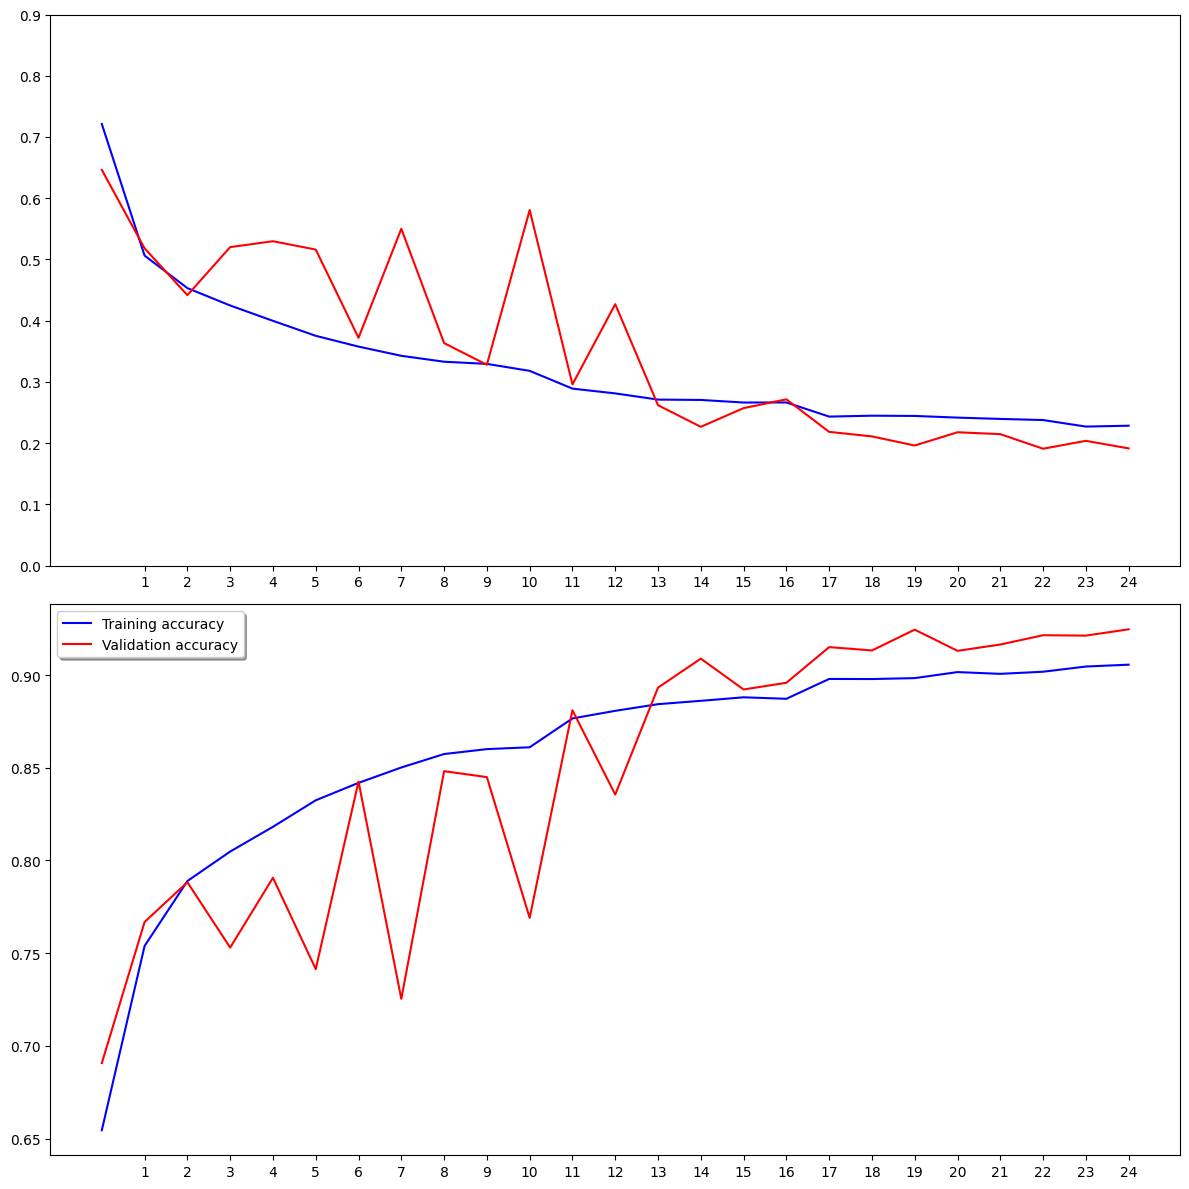

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

#Подготовка тестовой выборки

Разместим тестовые данные в DataFrame Pandas

In [44]:
test_filenames = os.listdir("/content/test/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [45]:
test_df.head()

,filename
0,6454.jpg
1,2779.jpg
2,909.jpg
3,3019.jpg
4,8305.jpg


#ImageDataGenerator для тестовых данных

In [46]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "/content/test/",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


#Прогноз результата
Для категориальной классификации предсказанием модели является вероятность для каждой категории, поэтому будем выбирать категорию с наибольшей вероятностью, используя функцию numpy average max

In [47]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

391/391 [==============================] - 20s 51ms/step


In [48]:
predict[:3]

array([[0.9973578 , 0.00264221],
       [0.9865406 , 0.01345936],
       [0.20804171, 0.7919583 ]], dtype=float32)

In [49]:
#test_df['label'] = np.argmax(predict, axis=-1)
test_df['label'] = predict[:,1]

Конвертируем названия категорий в обозначения классов

In [50]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['label'] = test_df['label'].replace(label_map)
test_df['label'] = test_df['label'].replace({ 'dog': 1, 'cat': 0 })

#Визуализация тестовых данных

<Axes: >

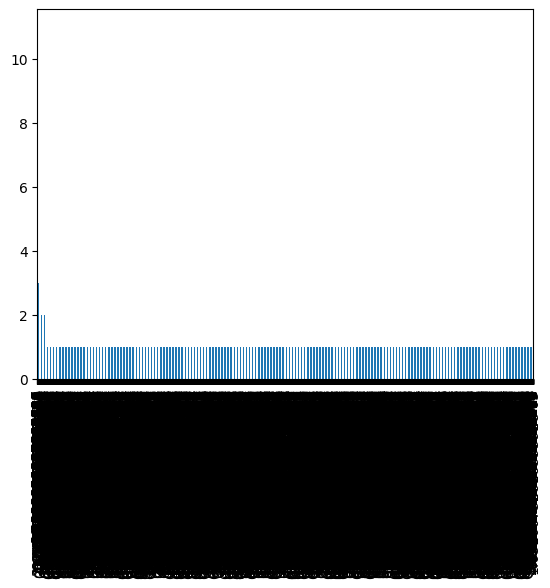

In [51]:
test_df['label'].value_counts().plot.bar()

#Результаты предсказаний модели

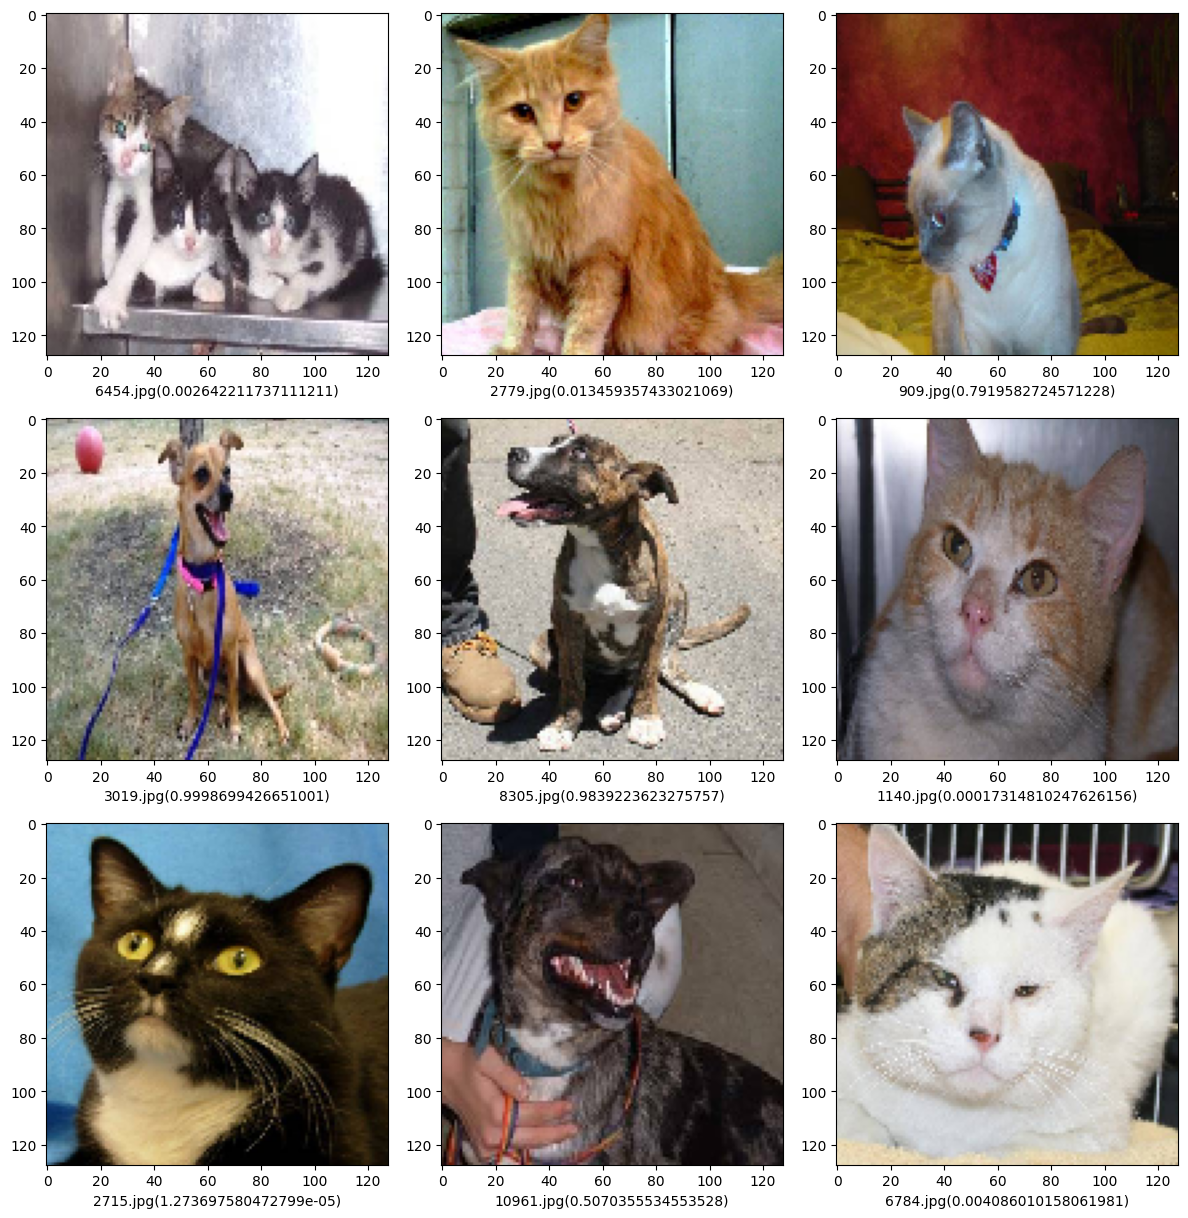

In [52]:
sample_test = test_df.head(9)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['label']
    img = load_img("/content/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Готовим файл с решением для Kaggle

#Submission

In [53]:
test_df.head()

,filename,label
0,6454.jpg,0.002642
1,2779.jpg,0.013459
2,909.jpg,0.791958
3,3019.jpg,0.999870
4,8305.jpg,0.983922


In [54]:
submission_df = test_df.copy()

In [55]:
submission_df.head()

,filename,label
0,6454.jpg,0.002642
1,2779.jpg,0.013459
2,909.jpg,0.791958
3,3019.jpg,0.999870
4,8305.jpg,0.983922


In [56]:
submission_df['id'] = submission_df['filename'].str.split('.').str[0]

In [57]:
submission_df.head()

,filename,label,id
0,6454.jpg,0.002642,6454
1,2779.jpg,0.013459,2779
2,909.jpg,0.791958,909
3,3019.jpg,0.999870,3019
4,8305.jpg,0.983922,8305


In [58]:
id=submission_df['id']

In [59]:
id

0         6454
1         2779
2          909
3         3019
4         8305
         ...  
12495     3960
12496     9974
12497     8425
12498     2329
12499    10165
Name: id, Length: 12500, dtype: object

In [60]:
submission_df.drop(labels=['id'], axis=1,inplace = True)
submission_df.insert(0, 'id', id)

In [61]:
submission_df.head()

,id,filename,label
0,6454,6454.jpg,0.002642
1,2779,2779.jpg,0.013459
2,909,909.jpg,0.791958
3,3019,3019.jpg,0.999870
4,8305,8305.jpg,0.983922


In [62]:
submission_df.drop(['filename'], axis=1, inplace=True)

In [63]:
submission_df.head()

,id,label
0,6454,0.002642
1,2779,0.013459
2,909,0.791958
3,3019,0.999870
4,8305,0.983922


In [64]:
submission_df.to_csv('submission.csv', index=False)

In [65]:
!head submission.csv

id,label
6454,0.002642211737111211
2779,0.013459357433021069
909,0.7919582724571228
3019,0.9998699426651001
8305,0.9839223623275757
1140,0.00017314810247626156
2715,1.273697580472799e-05
10961,0.5070355534553528
6784,0.004086010158061981


# Отправляем решение на соревнование

In [ ]:
!kaggle competitions submit -c dogs-vs-cats -m "Submition from Colab" -f submission.csv

100% 86.8k/86.8k [00:03<00:00, 22.7kB/s]
403 - Forbidden - You must accept the rules for this competition to perform this action.


In [66]:
!kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f submission.csv -m "Message"

100% 306k/306k [00:01<00:00, 287kB/s]
Successfully submitted to Dogs vs. Cats Redux: Kernels Edition

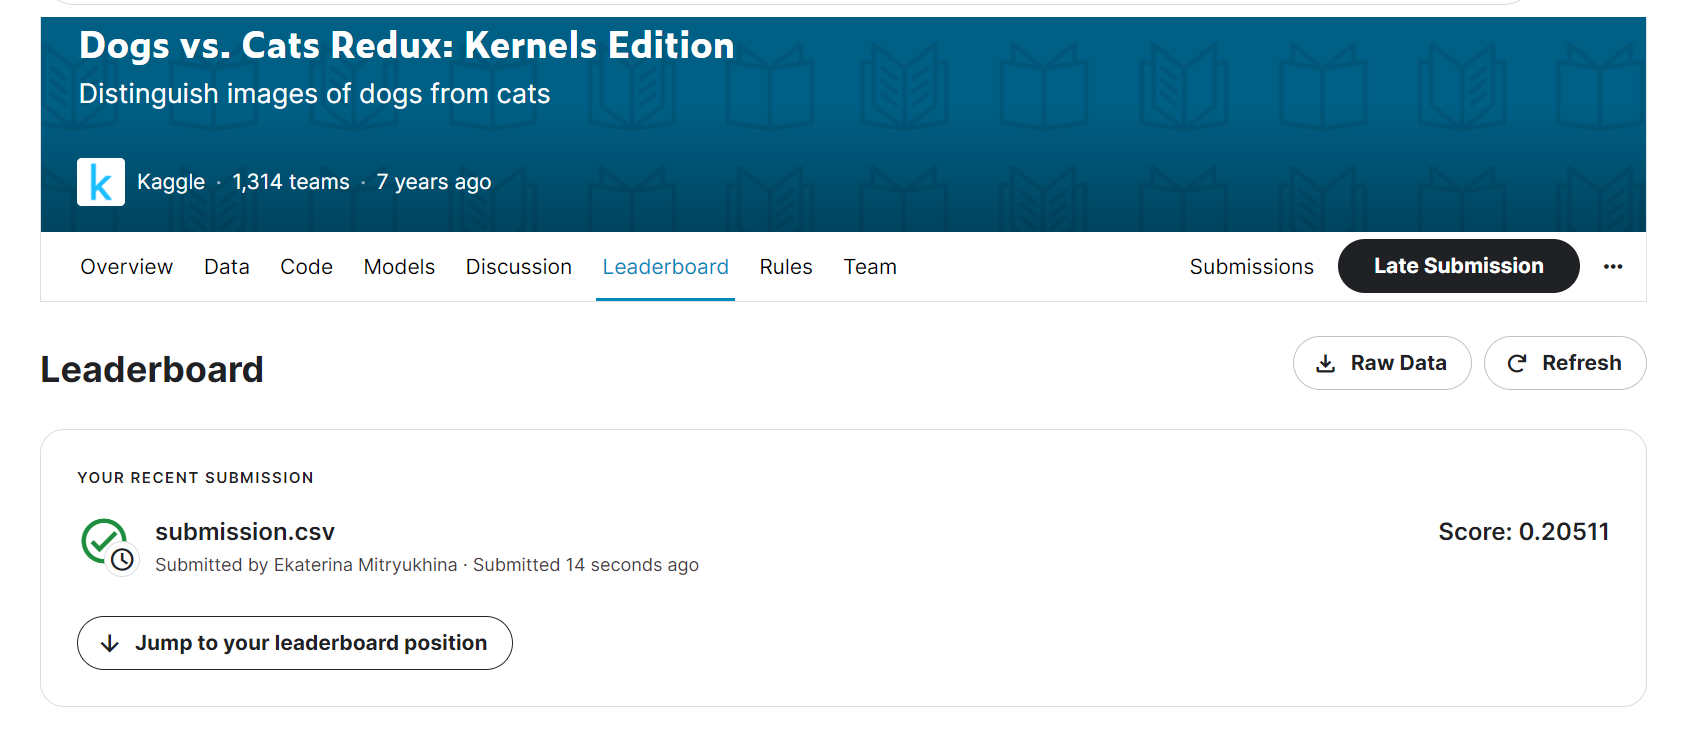